# IMU Fusion Algorithms
Comparing Fusion Algorithms

In [1]:
import os
import pandas as pd

In [17]:
path_to_dataset = 'datasets/'
datasets = os.listdir(path_to_dataset)

In [18]:
i = 0
for file in datasets:
    print(i,file)
    i+=1

0 2023-04-02_19-22-16
1 2023-04-19_07-21-10
2 2023-04-21_17-03-28
3 2023-06-02_06-34-39
4 2023-06-02_12-14-13
5 2023-06-02_13-28-32
6 2023-06-03_06-13-40
7 2023-06-03_07-09-39
8 2023-07-05_07-44-33
9 2023-07-26_06-26-10
10 Earley-2023-12-08_07-39-28
11 Forbury_Road_(stop_EL)-2023-11-28_14-02-13
12 global_wifi.csv
13 Station_Road-2023-12-08_07-53-14
14 Twyford_railway_station-2023-12-02_09-05-35


In [198]:
dataset = datasets[13]

data_df_file = 'datasets/'+dataset+'/combined_sensors.csv'
data_df_file

'datasets/Station_Road-2023-12-08_07-53-14/combined_sensors.csv'

In [199]:
import numpy as np
import matplotlib.pyplot as plt

Reading the dataset selected

In [200]:
df_imu = pd.read_csv(data_df_file,parse_dates=True)

Converting datetime to timestamp

In [201]:
df_imu['time'] = pd.to_datetime(df_imu['time'])
df_imu['time'] = df_imu['time'].astype('int64')

#### Dataset Description

In [202]:
print(
    "Duration:",
    round((df_imu['time'].values[-1] - df_imu['time'].values[0])/6e+10,2),
    " minutes"
)

Duration: 81.69  minutes


Extracting individual subsets

In [203]:
time = df_imu['time'].values
accelerometer_data = df_imu[['x_acc', 'y_acc', 'z_acc']].values
gyroscope_data = df_imu[['x_gyro', 'y_gyro', 'z_gyro']].values
magnetometer_data = df_imu[['x_mag', 'y_mag', 'z_mag']].values

## Ground Truth

In [204]:
df_gps = pd.read_csv('datasets/'+dataset+'/gps.csv')

In [205]:
print("IMU Datapoints:",df_imu.shape)
print("GPS Datapoints:",df_gps.shape)

IMU Datapoints: (15382, 10)
GPS Datapoints: (15382, 11)


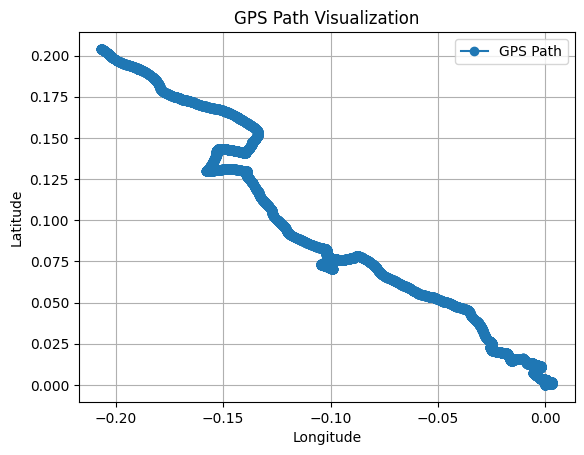

In [206]:
def gpsgraph(df_gps):
    # Extract GPS data
    # time_gps = df_gps['time'].values
    longitude_gps = df_gps['longitude'].values
    latitude_gps = df_gps['latitude'].values

    latitude_gps = latitude_gps - latitude_gps[0]
    longitude_gps = longitude_gps  - longitude_gps[0]

    # Plot the GPS path
    plt.figure()
    plt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('GPS Path Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()
gpsgraph(df_gps)

## Determining position change from GPS Coordinates

In [207]:
df = df_imu.copy()
df['latitude'] = df_gps['latitude']
df['longitude'] = df_gps['longitude']

In [208]:
df2 = df.groupby(['latitude','longitude'],as_index=False).first()
df2 = df.drop(columns=['latitude','longitude']).merge(df2[['latitude','longitude','time']],on=['time'],how='left')
df2

,time,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,x_mag,y_mag,z_mag,latitude,longitude
0,1702021994466597000,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,51.457720,-0.972102
1,1702021994468987600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,NaN,NaN
2,1702021994677308700,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-211.425003,-92.700005,368.700012,NaN,NaN
3,1702021995426736600,-0.02205,2.71905,10.207951,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,NaN,NaN
4,1702021995427619000,0.38700,2.85105,8.805000,0.330825,-0.423912,-0.473962,-212.925003,-93.787506,368.287506,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15377,1702026894775270000,1.40205,-0.87405,8.473050,-0.298788,-0.086213,0.294113,-193.912506,-105.300003,359.418762,51.661707,-1.178784
15378,1702026894983986700,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-193.912506,-105.300003,359.418762,NaN,NaN
15379,1702026895234652000,1.40205,-0.87405,8.473050,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,NaN,NaN
15380,1702026895729403600,-0.32100,-0.98400,9.564000,-0.371250,-0.415388,-0.521812,-190.781250,-109.800003,359.512512,51.661717,-1.178793


In [209]:
df_int = df2.drop_duplicates(subset=['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro','latitude','longitude']).interpolate()

In [210]:
df_int['x_change'] = df_int['longitude'].diff()
df_int['y_change'] = df_int['latitude'].diff()

In [211]:
df_int.fillna(0,inplace=True)

In [242]:
df_int.columns

Index(['time', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro',
       'x_mag', 'y_mag', 'z_mag', 'latitude', 'longitude', 'x_change',
       'y_change'],
      dtype='object')

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [213]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

In [243]:
cols_X = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro','x_mag', 'y_mag', 'z_mag']
cols_Y = ['x_change','y_change']

In [244]:
X = df_int[cols_X].values
y = df_int[cols_Y].values

In [245]:
y.shape

(12536, 2)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [247]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Creating and training the MultiOutputRegressor with SVR
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
multioutput_regressor = MultiOutputRegressor(svr_model)
multioutput_regressor.fit(X_train_scaled, y_train_scaled)

# Making predictions on the test set
X_test_scaled = scaler_X.transform(X_test)
y_pred_scaled = multioutput_regressor.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Calculating Mean Squared Error (MSE) for each target
mse1 = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse2 = mean_squared_error(y_test[:, 1], y_pred[:, 1])


In [248]:
mse1,mse2

(2.348096315611463e-10, 1.410099100990444e-10)

In [273]:
path_to_dataset = 'datasets/'
datasets = os.listdir(path_to_dataset)
dataset = datasets[14]

data_df_file = 'datasets/'+dataset+'/combined_sensors.csv'
data_df_file

'datasets/Twyford_railway_station-2023-12-02_09-05-35/combined_sensors.csv'

In [274]:
df_gps_test = pd.read_csv('datasets/'+dataset+'/gps.csv',parse_dates=True)
df_imu_test = pd.read_csv(data_df_file,parse_dates=True)

print("IMU Datapoints:",df_imu_test.shape)
print("GPS Datapoints:",df_gps_test.shape)

IMU Datapoints: (3535, 10)
GPS Datapoints: (3535, 11)


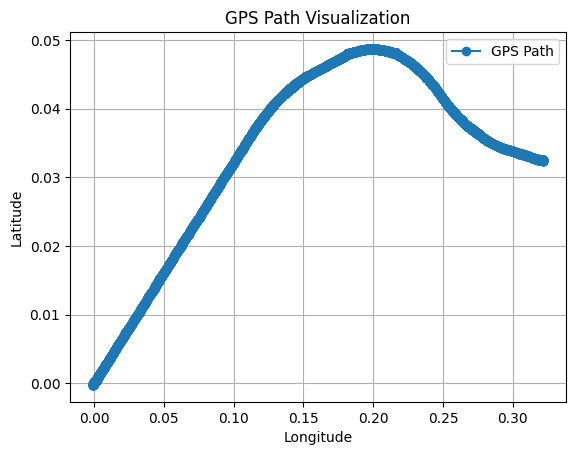

In [275]:
gpsgraph(df_gps_test)

In [276]:
X_input = df_imu_test[cols_X].values

In [277]:
X_input_scaled = scaler_X.transform(X_input)

In [278]:
preds = multioutput_regressor.predict(X_input_scaled)

In [279]:
df_pred = pd.DataFrame()
df_pred['longitude_change'] = preds[:,0]
df_pred['latitude_change'] = preds[:,1]

df_pred['longitudes'] = np.cumsum(df_pred['longitude_change'].values)
df_pred['latitudes'] = np.cumsum(df_pred['latitude_change'].values)

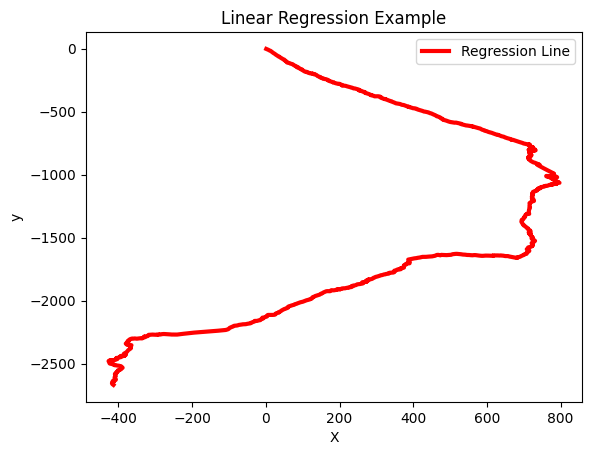

In [281]:
plt.plot(df_pred['longitudes'],df_pred['latitudes'], color='red', linewidth=3, label='Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()